We'll start by importing all necessary libraries.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import tree
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import visualkeras
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm_notebook
from sklearn.tree import export_graphviz

In [2]:
df_train1 = pd.read_csv('data/NBA_PBP_2015-16.csv')
df_train2 = pd.read_csv('data/NBA_PBP_2016-17.csv')
df_train3 = pd.read_csv('data/NBA_PBP_2017-18.csv')
df_train4 = pd.read_csv('data/NBA_PBP_2018-19.csv')
df_train5 = pd.read_csv('data/NBA_PBP_2019-20.csv')

del df_train5['Unnamed: 40']

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5])

df_train.to_csv('all_seasons.csv', index=False)

df_train = df_train.reset_index(drop=True)

df_test = pd.read_csv('test data/NBA_PBP_2020-21.csv')


In [26]:
factors = ['ShotDist','TimeoutTeam','Substitution', 'Shooter',
           'Rebounder', 'Blocker','Fouler',
          'ReboundType','ViolationPlayer',
          'FreeThrowShooter','TurnoverPlayer']

fact_cols = [col + str((i // 11) % 10 + 1) for i, col in enumerate(factors * 10)]
fact_cols.append('class')

In [5]:
df_train['ShotDist'] = df_train.ShotDist.apply(lambda x: 'close' if x <= 10 else '3pt' if x >= 22 else 'mid' if pd.notna(x) else x)

df_train['TimeoutTeam'] = df_train.apply(
    lambda row: 'timeout_home' if pd.notna(row['TimeoutTeam']) and row['TimeoutTeam'] == row['HomeTeam'] 
    else 'timeout_away' if pd.notna(row['TimeoutTeam']) 
    else row['TimeoutTeam'], 
    axis=1
)

df_train['Shooter'] = df_train.apply(lambda row: 'shooter_home' if pd.notna(row['Shooter']) and pd.notna(row['HomePlay'])
                                     else 'shooter_away' if pd.notna(row['Shooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Rebounder'] = df_train.apply(lambda row: 'rebounder_home' if pd.notna(row['Rebounder']) and pd.notna(row['HomePlay'])
                                     else 'rebounder_away' if pd.notna(row['Rebounder']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Blocker'] = df_train.apply(lambda row: 'blocker_home' if pd.notna(row['Blocker']) and pd.notna(row['HomePlay'])
                                     else 'blocker_away' if pd.notna(row['Blocker']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Fouler'] = df_train.apply(lambda row: 'fouler_home' if pd.notna(row['Fouler']) and pd.notna(row['HomePlay'])
                                     else 'fouler_away' if pd.notna(row['Fouler']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)


df_train['ViolationPlayer'] = df_train.apply(lambda row: 'violator_home' if pd.notna(row['ViolationPlayer']) and pd.notna(row['HomePlay'])
                                     else 'violator_away' if pd.notna(row['ViolationPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['FreeThrowShooter'] = df_train.apply(lambda row: 'ft_home' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['HomePlay'])
                                     else 'ft_away' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['TurnoverPlayer'] = df_train.apply(lambda row: 'to_player_home' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['HomePlay'])
                                     else 'to_player_away' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)


df_train['Substitution'] = df_train.apply(lambda row: 'sub_home' if pd.notna(row['EnterGame']) and pd.notna(row['HomePlay'])
                                              else 'sub_away' if pd.notna(row['EnterGame']) and pd.notna(row['AwayPlay'])
                                              else np.nan,
                                              axis=1)



In [6]:
def home_runner(data):
    global home_runs
    run = []
    home_runs = []
    for idx in data.index:
        if data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.append(idx)
        elif data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.clear()
        if len(run) == 4:
            home_runs.append(run.copy())
            run.clear()
    return home_runs
                

home_runner(df_train)



def away_runner(data):
    global away_runs
    run = []
    away_runs = []
    for idx in data.index:
        if data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.append(idx)
        elif data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.clear()
        if len(run) == 4:
            away_runs.append(run.copy())
            run.clear()
    return away_runs

away_runner(df_train)

all_runs = []
all_runs.extend(home_runs)
all_runs.extend(away_runs)


In [7]:
df_train = df_train[factors]

In [57]:
def runs_iter(data, runs):
    global runs_df
    runs_df = pd.DataFrame()
    for run in runs:
        a = data.loc[run[0]-10:run[0]-1, factors].values.ravel()
        a = np.append(a,1)
        runs_df = pd.concat([runs_df,pd.DataFrame([a.copy()])])
    return runs_df

runs_iter(df_train, home_runs)
runs_df.columns = fact_cols
runs_df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1
0,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home

In [58]:
def no_runs_preprocessing(data, runs):
    global no_runs_split
    
    # find the first index of a run
    r = [i[0] for i in runs]  

    # create a list of runs
    r_x = []
    for num in r:
        r_x.extend(range(num - 10, num + 1))

    # mask the df without runs
    no_runs_df = data[~data.index.isin(r_x)].reset_index(drop=True)

    # segment the df and keep those that are length of 10
    segment_size = 10
    segments = len(no_runs_df) // segment_size

    no_runs_split = np.array_split(no_runs_df, segments)

    no_runs_split = [x for x in no_runs_split if len(x) != 11]

    return no_runs_split

In [59]:
def no_runs_optimized(data, factors, fact_cols):
    global no_runs_df
    no_runs_df = pd.DataFrame([np.append(segment.loc[:, factors].values.ravel(), int(0)) for segment in data])
    no_runs_df.columns = fact_cols
    return no_runs_df

no_runs_optimized(no_runs_preprocessing(df_train, home_runs), factors, fact_cols)

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,0
1,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,violator_home,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_aw

In [61]:
combined_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
combined_df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1
1,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home

In [62]:
combined_df.to_csv('home_runs.csv', index=False)

In [63]:
combined_df = pd.read_csv('gen_sets/home_runs.csv')
combined_df

C:\Users\gsevr\AppData\Local\Temp\ipykernel_11376\3383087585.py:1: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('gen_sets/home_runs.csv')


,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1
1,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home

In [64]:
df = pd.DataFrame()
encoders = []

for column in combined_df.columns[:-1]:
    le = LabelEncoder()
    encoders.append(le)
    df[column] = le.fit_transform(combined_df[column])

C:\Users\gsevr\AppData\Local\Temp\ipykernel_11376\172710995.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11376\172710995.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11376\172710995.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [65]:
df = pd.concat([df,combined_df.iloc[:,-1]],axis=1)
df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,3,2,2,2,2,2,0,2,2,2,2,3,2,2,2,2,2,2,2,2,0,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,0,1
1,3,2,2,2,0,2,2,1,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,0,2,2,1,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,1
2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,0,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,0,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,1
3,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,0,2,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,3,2,0,2,2,2,2,2,2,2,2,1
4,3,2,2,2,2,2,2,2,2,2,0,1,2,2,1,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,0,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292442,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,0,2,2,1,2,2,2,2,2,2,2,3,2,2,2,1,2,2,1,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,1,2,2,1,2,2,2,1,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,1,2,2,0,2,0,2,2,2,2,2,0
292443,3,2,2,2,0,2,2,1,2,2,2,3,2,2,2,2,2,2,2,2,2,0,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,0,3,2,0,2,2,2,2,2,2,2,2,0
292444,3,2,2,2,2,2,2,2,2,2,1,3,0,2,2,2,2,2,2,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,3,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,0,2,2,1,2,2,2,2,2,2,2,0
292445,3,2,2,2,2,2,2,2,2,2,0,0,2,2,1,2,2,2,2,2,2,2,3,0,2,2,2,2,2,2,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,0,2,2,2,2,2,2,2,2,3,2,1,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,0,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,0


In [66]:
undersample_df = df[df['class'] == 0 ].sample(n=len(df[df['class'] == 1]),random_state=43)
df = pd.concat([df[df['class'] == 1], undersample_df])

In [67]:
df['class'].value_counts()

class
1    18471
0    18471
Name: count, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],df.iloc[:, -1], 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

In [71]:
sal = X_train[y_train == 1]

In [47]:
num_categories = 2
y_train = keras.utils.to_categorical(y_train.values, num_categories)
y_test = keras.utils.to_categorical(y_test.values, num_categories)

In [48]:
a = X_train.values.reshape(-1,10,11)
b = X_test.values.reshape(-1,10,11)

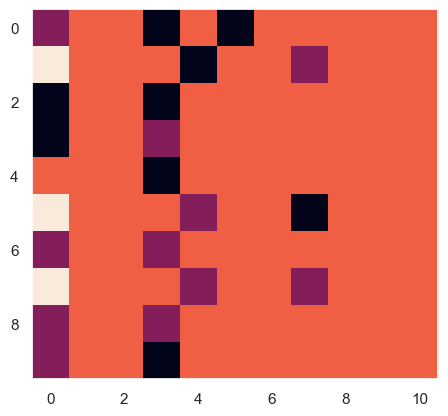

In [51]:
plt.imshow(a[30])
plt.grid(False)
plt.show()

In [52]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(50, (5, 5), strides=1, padding="same", activation="relu", input_shape=(10,11,1)))   
model.add(MaxPool2D((2, 2), strides=1, padding="same"))
model.add(Conv2D(25,(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D((2, 2), strides=1, padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=32, activation="relu"))


model.add(Dense(units=num_categories, activation="softmax"))
model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer='rmsprop')

C:\Users\gsevr\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5200 - loss: 0.6869 - val_accuracy: 0.7265 - val_loss: 0.5240
Epoch 2/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7189 - loss: 0.5333 - val_accuracy: 0.7456 - val_loss: 0.4917
Epoch 3/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7449 - loss: 0.5020 - val_accuracy: 0.7445 - val_loss: 0.4990
Epoch 4/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7488 - loss: 0.4928 - val_accuracy: 0.7526 - val_loss: 0.4719
Epoch 5/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7506 - loss: 0.4843 - val_accuracy: 0.7341 - val_loss: 0.4919
Epoch 6/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7503 - loss: 0.4789 - val_accuracy: 0.7596 - val_loss: 0.4708
Epoch 7/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7557 - loss: 0.4759 - val_accuracy: 0.7567 - val_loss: 0.4712
Epoch 8/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7658 - loss: 0.4664 - val_accuracy: 0.

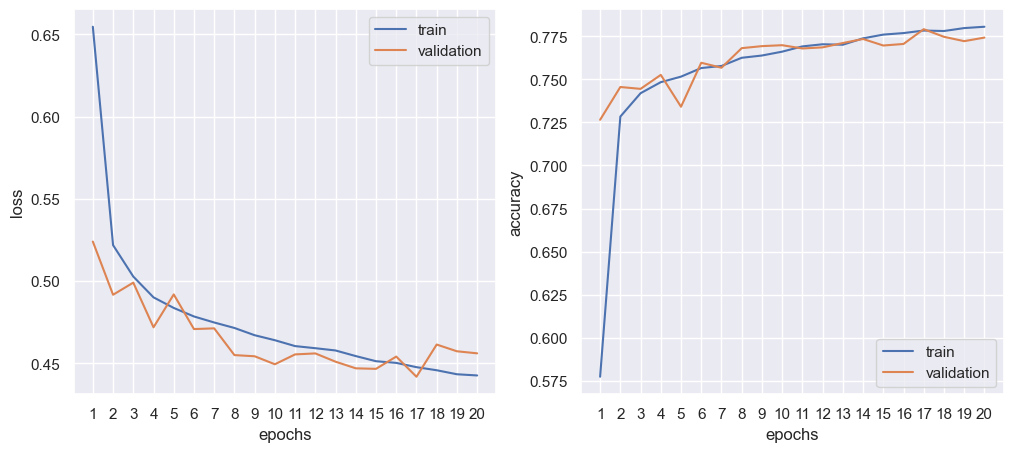

809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.67      0.75     12915
           1       0.73      0.90      0.81     12944

    accuracy                           0.78     25859
   macro avg       0.80      0.78      0.78     25859
weighted avg       0.80      0.78      0.78     25859



In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5,verbose=1,monitor='val_accuracy')

history = model.fit(
    a, y_train, epochs=20, verbose=1, validation_data=(b, y_test),callbacks=[early_stopping])

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

stopped_epoch = len(history.history['loss'])

plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1,2,1)
plt.plot(range(1, stopped_epoch + 1), history.history['loss'])
plt.plot(range(1, stopped_epoch + 1), history.history['val_loss'])
plt.xticks([i for i in range(1, stopped_epoch + 1)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper right')

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(range(1, stopped_epoch + 1), history.history['accuracy'])
plt.plot(range(1, stopped_epoch + 1), history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.xticks([i for i in range(1, stopped_epoch + 1)])

plt.show()


from sklearn.metrics import classification_report
preds = model.predict(a)

print(classification_report(np.argmax(y_train,axis=1), np.argmax(preds,axis=1)))

In [15]:
def loss(x_partial):
    full_input = tf.concat([x_partial, x_missing], axis=1)  
    full_input = tf.expand_dims(full_input, axis=0)  # batch dim

    # model predictions
    predictions = model(full_input)

    # probability of the 'run' class
    run_probability = predictions[0, 1]

    # negative log probability 
    return -tf.math.log(run_probability + 1e-8)  # epsilon to avoid log(0)

def confidence_metric(loss_value, length, max_len=10, alpha=1.0):
    normalized_length = length / max_len
    
    confidence = (1 / (1 + alpha * loss_value)) * normalized_length
    return confidence

ranges = {}
confidences = {}

for i in range(1, 10):
    gen_preds = []
    confs = []
    for arr in b[:5]:
        rand_len = i
        
        arr_partial = arr[:, :rand_len].reshape(11, rand_len, 1)

        x_missing = tf.Variable(np.random.rand(11, 10 - rand_len, 1), dtype=tf.float32)

        optimizer = tf.optimizers.Adam(learning_rate=0.01)

        loss_value = None  
        for step in range(500):
            with tf.GradientTape() as tape:
                loss_value = loss(arr_partial)

            grads = tape.gradient(loss_value, [x_missing])

            optimizer.apply_gradients(zip(grads, [x_missing]))

        missing = np.clip(np.round(x_missing.numpy()), 0, 3)
        
        full = np.concatenate([arr_partial, missing], axis=1)
        
        exp_full = np.expand_dims(full, axis=0)
        
        pred = np.argmax(model.predict(exp_full))
        
        gen_preds.append(pred)
        
        confidence = confidence_metric(loss_value.numpy(), rand_len)
        confs.append(confidence)

    ranges[i] = gen_preds
    confidences[i] = confs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [181]:
for i in range(1,10):
    print(np.mean(ranges[i]), np.mean(confidences[i]))

0.8 0.09912429903469257
0.6 0.19814672626830093
1.0 0.29745843917945136
1.0 0.39617233635787985
1.0 0.49544063644645214
0.8 0.5742160065347074
0.8 0.585055392912568
0.8 0.676785357008714
1.0 0.7604213983847115


In [105]:
predicted_full = pd.DataFrame(full.reshape(-1,110))
predicted_full.columns = X_train.columns

In [106]:
predicted_full = predicted_full.astype(int)
predicted_full

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10
0,3,2,2,2,2,0,2,0,1,0,0,1,2,2,1,0,1,1,0,0,2,2,3,0,2,0,0,0,0,1,2,2,2,3,2,0,0,1,1,1,2,2,2,2,3,0,0,0,2,0,2,2,2,2,2,0,0,2,1,0,2,2,2,2,2,1,1,1,1,0,2,2,2,2,2,0,1,0,1,0,1,2,2,2,2,1,1,1,0,0,2,2,0,2,2,0,1,1,1,1,2,2,2,2,2,1,0,0,1,1


In [107]:
rules = []
for encoder, column in zip(encoders, predicted_full.columns):
    rules.append(encoder.inverse_transform(predicted_full[column])[0])

In [108]:
generated_rules = pd.DataFrame(rules).T
generated_rules.columns = X_train.columns
generated_rules

In [56]:
model.save('pretrained_model_le.keras')
np.save('training_history_le.npy', history.history)

In [72]:
def compute_saliency_map(model, input_image):
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Create a tensor for the input and make it watchable for gradient computation
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # Ensure that the input tensor is being tracked by the gradient tape
        tape.watch(input_tensor)

        # Get the model's prediction for the input image
        prediction = model(input_tensor)

        output_value = prediction

    # Compute the gradients of the output with respect to the input image
    gradients = tape.gradient(output_value, input_tensor)
    
    saliency = np.abs(gradients.numpy())

    # Remove the batch dimension for visualization purposes
    saliency = np.squeeze(saliency)

    return saliency

def compute_saliency_for_dataset(model, dataset):
    num_samples = len(dataset)
    saliency_sum = None

    # Loop through each sample in the dataset
    for i, sample in enumerate(dataset):
        print(f"Processing sample {i+1}/{num_samples}")
        
        # Compute the saliency map for the current sample
        saliency_map = compute_saliency_map(model, sample)

        # Initialize saliency_sum if it's the first sample
        if saliency_sum is None:
            saliency_sum = saliency_map
        else:
            # Accumulate the saliency maps
            saliency_sum += saliency_map

    # Average the saliency maps across all samples
    saliency_avg = saliency_sum / num_samples

    return saliency_avg

saliency_avg_map = compute_saliency_for_dataset(model, sal.values.reshape(-1,10,11))



Processing sample 1/12944
Processing sample 2/12944
Processing sample 3/12944
Processing sample 4/12944
Processing sample 5/12944
Processing sample 6/12944
Processing sample 7/12944
Processing sample 8/12944
Processing sample 9/12944
Processing sample 10/12944
Processing sample 11/12944
Processing sample 12/12944
Processing sample 13/12944
Processing sample 14/12944
Processing sample 15/12944
Processing sample 16/12944
Processing sample 17/12944
Processing sample 18/12944
Processing sample 19/12944
Processing sample 20/12944
Processing sample 21/12944
Processing sample 22/12944
Processing sample 23/12944
Processing sample 24/12944
Processing sample 25/12944
Processing sample 26/12944
Processing sample 27/12944
Processing sample 28/12944
Processing sample 29/12944
Processing sample 30/12944
Processing sample 31/12944
Processing sample 32/12944
Processing sample 33/12944
Processing sample 34/12944
Processing sample 35/12944
Processing sample 36/12944
Processing sample 37/12944
Processing

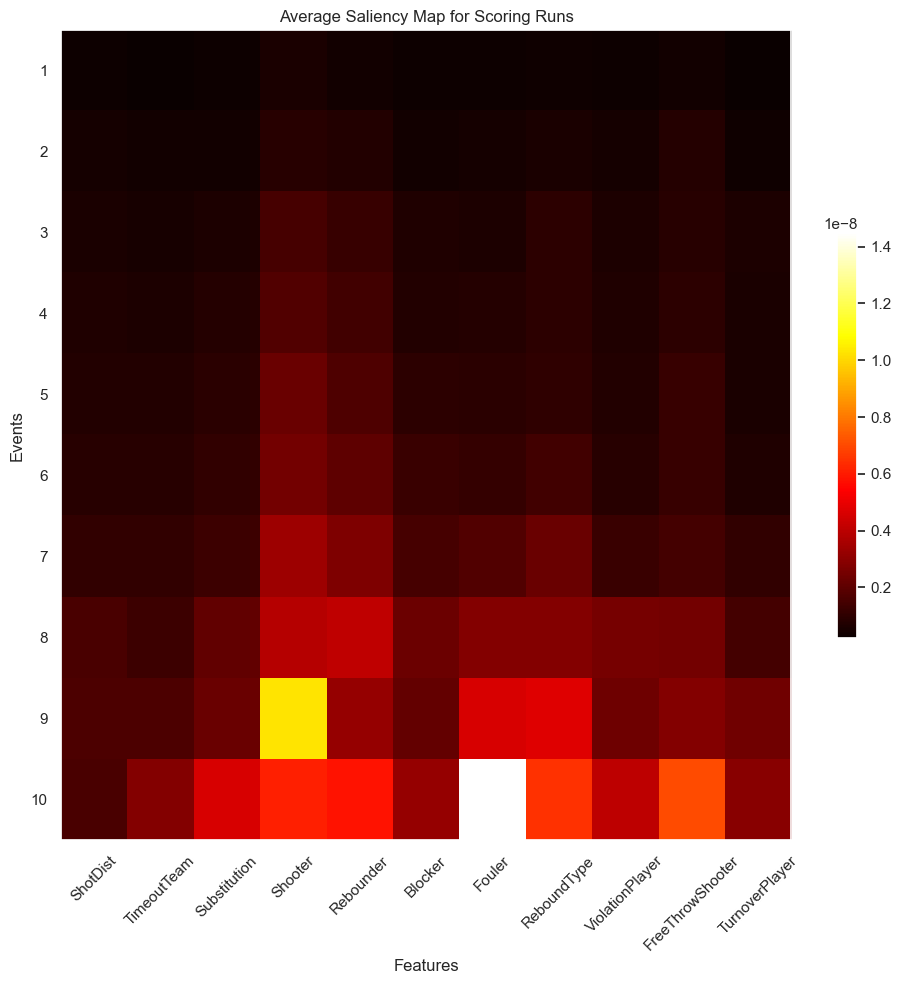

In [75]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 10))

plt.imshow(saliency_avg_map, cmap='hot', aspect='auto')

plt.grid(False)
plt.axis('on')

plt.title('Average Saliency Map for Scoring Runs')
plt.ylabel('Events')
plt.xlabel('Features')
plt.xticks(np.arange(len(factors)), factors, rotation=45) 
plt.yticks(np.arange(10), [i for i in range(1, 11)])     

plt.colorbar(shrink=0.5)


plt.tight_layout()

plt.show()


In [12]:
def trad_class(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier()
    dtc = DecisionTreeClassifier()
    svc = SVC()
    knc = KNeighborsClassifier()

    clfs = [rfc, dtc, svc, knc]
    preds = {}

    for clf in clfs:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        preds[clf] = pred
        print(classification_report(y_test,pred))

    return preds


trad_class(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      5556
           1       0.74      0.83      0.78      5527

    accuracy                           0.77     11083
   macro avg       0.77      0.77      0.77     11083
weighted avg       0.77      0.77      0.77     11083

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      5556
           1       0.72      0.70      0.71      5527

    accuracy                           0.72     11083
   macro avg       0.72      0.72      0.72     11083
weighted avg       0.72      0.72      0.72     11083

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      5556
           1       0.67      0.87      0.76      5527

    accuracy                           0.73     11083
   macro avg       0.75      0.73      0.72     11083
weighted avg       0.75      0.73      0.72     11083

              preci

{RandomForestClassifier(): array([0, 1, 1, ..., 1, 0, 1], dtype=int64),
 DecisionTreeClassifier(): array([0, 1, 0, ..., 1, 1, 0], dtype=int64),
 SVC(): array([0, 1, 1, ..., 1, 0, 1], dtype=int64),
 KNeighborsClassifier(): array([1, 1, 1, ..., 1, 0, 1], dtype=int64)}